https://github.com/AdityaVashista30/Image-generation-using-GANS-using-PyTorch-and-Cifar-10

In [1]:
#torch cuda
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# Deep Convolutional GANs

# Importing the libraries
import os
import numpy as np
from PIL import Image
import cv2
import numpy as np
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import errno

# Setting some hyperparameters
batchSize = 64
imageSize = 64

# Creating list of transformations (scaling, tensor conversion, normalization) to apply to the input images.
#transform = transforms.Compose([transforms.Resize(imageSize), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])

# Loading the dataset
#dataset = dset.CIFAR10(root = './data', download = True, transform = transform) # download the training set in the ./data folder and we apply transformations
#dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle = True, num_workers = 2) # We use dataLoader to get the images of the training set batches

class CustomDataset(data.Dataset):
    def __init__(self, X_folder, y_folder, transform=None):
        self.X_folder = X_folder
        self.y_folder = y_folder
        self.transform = transform

        # Obtener la lista de nombres de archivo en las carpetas
        self.X_filenames = [filename for filename in os.listdir(X_folder) if filename.endswith('.jpg')]
        self.y_filenames = [filename for filename in os.listdir(y_folder) if filename.endswith('.jpg')]

    def __len__(self):
        return len(self.X_filenames)

    def __getitem__(self, index):
        # Obtener el nombre de archivo correspondiente a la posición del índice
        X_filename = self.X_filenames[index]
        y_filename = self.y_filenames[index]

        # Verificar si el archivo tiene la extensión ".jpg"
        if not X_filename.endswith(".jpg"):
            return self.__getitem__((index + 1) % len(self))

        # Cargar las imágenes y las etiquetas
        X = Image.open(os.path.join(self.X_folder, X_filename)).convert("RGB")
        y = Image.open(os.path.join(self.y_folder, y_filename)).convert("RGB")

        if self.transform:
            X = self.transform(X)
            y = self.transform(y)

        return X, y

    def get_images(self):
        images = []
        for X_filename in self.X_filenames:
            X = Image.open(os.path.join(self.X_folder, X_filename))
            if self.transform:
                X = self.transform(X)
            images.append(X)
        return images

    def get_labels(self):
            labels = []
            for y_filename in self.y_filenames:
                y = Image.open(os.path.join(self.y_folder, y_filename))
                if self.transform:
                    y = self.transform(y)
                labels.append(y)
            return labels


# Definir las rutas de las carpetas de entrenamiento y prueba
trainX_folder = '/content/gdrive/MyDrive/Dev/AI_MsC/TFM/CRACK500/traindata/traindata/'
trainy_folder = '/content/gdrive/MyDrive/Dev/AI_MsC/TFM/CRACK500/valdata/valdata/'
#testX_folder = './dataset/testX'
#testy_folder = './dataset/testy'

# Crear las transformaciones
transform = transforms.Compose([
    transforms.Resize((imageSize,imageSize)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
])

# Crear el dataset personalizado de entrenamiento
dataset_full = CustomDataset(trainX_folder, trainy_folder, transform=transform)
# Obtener xtrain e ytrain
dataset = dataset_full.get_images()
print(dataset[0].shape)

# Crear el dataset personalizado de prueba
#test_dataset = CustomDataset(testX_folder, testy_folder, transform=transform)

# Crear los dataloaders
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True, num_workers=2)
#test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batchSize, shuffle=False, num_workers=2)



# Defining the weights_init function that takes as input a neural network m and that will initialize all its weights.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# Defining the generator

class G(nn.Module): # We introduce a class to define the generator.

    def __init__(self):
        super(G, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias = False),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.main(input)
        return output

# Creating the generator
netG = G()
netG.apply(weights_init)

# Defining the discriminator

class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(64, 128, 4, 2, 1, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(128, 256, 4, 2, 1, bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(256, 512, 4, 2, 1, bias = False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(512, 1, 4, 1, 0, bias = False),
            nn.Sigmoid()
            )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1) # output will have a value between 0 and 1 i.e flatten


# Creating the discriminator
netD = D()
netD.apply(weights_init)


# Training the DCGANs
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr = 0.0002, betas = (0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = 0.0002, betas = (0.5, 0.999))

#Generar carpetas para almacenar las imágenes creadas
try:
    os.mkdir('/content/gdrive/MyDrive/Dev/AI_MsC/TFM/BestNotebooks/GAN-Simple_Pablo_v1/')
    os.mkdir('/content/gdrive/MyDrive/Dev/AI_MsC/TFM/BestNotebooks/GAN-Simple_Pablo_v1/Images')
    os.mkdir('/content/gdrive/MyDrive/Dev/AI_MsC/TFM/BestNotebooks/GAN-Simple_Pablo_v1/Images/fake_samples')
    os.mkdir('/content/gdrive/MyDrive/Dev/AI_MsC/TFM/BestNotebooks/GAN-Simple_Pablo_v1/models')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise


for epoch in range(70):
    for i, data in enumerate(dataloader, 0): # iterate over the images of the dataset.
        # 1st Step: Updating the weights of the neural network of the discriminator
        netD.zero_grad()
        real = data # real image of the dataset
        input = Variable(real) # wrap it in a variable.
        target = torch.tensor(torch.ones(input.size()[0])) # We get the target.
        output = netD(input)
        errD_real = criterion(output, target)

        # Training the discriminator with a fake image generated by the generator
        noise = Variable(torch.randn(input.size()[0], 100, 1, 1))
        fake = netG(noise)
        target = Variable(torch.zeros(input.size()[0]))
        output = netD(fake.detach())
        errD_fake = criterion(output, target)

        # Backpropagating the total error
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()

        # 2nd Step: Updating the weights of the neural network of the generator

        netG.zero_grad()
        target = Variable(torch.ones(input.size()[0]))
        output = netD(fake)
        errG = criterion(output, target)
        errG.backward()
        optimizerG.step()

        # 3rd Step: Printing the losses and saving the real images and the generated images of the minibatch every 100 steps

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' % (epoch+1, 70, i+1, len(dataloader), errD.data, errG.data))
        if i % 100 == 0: # Every 100 steps:
            vutils.save_image(real, '/content/gdrive/MyDrive/Dev/AI_MsC/TFM/BestNotebooks/GAN-Simple_Pablo_v1/Images/real_samples.png', normalize = True) # We save the real images of the minibatch.
            fake = netG(noise) # We get our fake generated images.
            vutils.save_image(fake.detach(), f'/content/gdrive/MyDrive/Dev/AI_MsC/TFM/BestNotebooks/GAN-Simple_Pablo_v1/Images/fake_samples/fake_samples_epoch_{epoch:03d}.png', normalize=True) # We also save the fake generated images of the minibatch.


torch.Size([1, 64, 64])


<ipython-input-5-10212c56a87c>:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(torch.ones(input.size()[0])) # We get the target.


[1/70][1/4] Loss_D: 1.5804 Loss_G: 7.0227
[1/70][2/4] Loss_D: 0.8122 Loss_G: 4.6209
[1/70][3/4] Loss_D: 1.6202 Loss_G: 6.3373
[1/70][4/4] Loss_D: 0.8495 Loss_G: 6.7656
[2/70][1/4] Loss_D: 0.8271 Loss_G: 7.2864
[2/70][2/4] Loss_D: 0.8936 Loss_G: 7.4130
[2/70][3/4] Loss_D: 1.0508 Loss_G: 8.2949
[2/70][4/4] Loss_D: 0.8626 Loss_G: 6.5581
[3/70][1/4] Loss_D: 0.7382 Loss_G: 10.5229
[3/70][2/4] Loss_D: 0.2444 Loss_G: 8.2455
[3/70][3/4] Loss_D: 1.1195 Loss_G: 12.5887
[3/70][4/4] Loss_D: 0.6142 Loss_G: 8.9040
[4/70][1/4] Loss_D: 1.3230 Loss_G: 13.1276
[4/70][2/4] Loss_D: 0.5718 Loss_G: 10.0528
[4/70][3/4] Loss_D: 1.0431 Loss_G: 10.7368
[4/70][4/4] Loss_D: 0.6792 Loss_G: 10.4690
[5/70][1/4] Loss_D: 0.6063 Loss_G: 12.6432
[5/70][2/4] Loss_D: 0.3184 Loss_G: 10.0729
[5/70][3/4] Loss_D: 0.9624 Loss_G: 14.9314
[5/70][4/4] Loss_D: 0.6653 Loss_G: 10.7177
[6/70][1/4] Loss_D: 0.5140 Loss_G: 11.2603
[6/70][2/4] Loss_D: 0.4901 Loss_G: 12.8687
[6/70][3/4] Loss_D: 0.4110 Loss_G: 9.6810
[6/70][4/4] Loss_D: 2.

In [6]:
# Guardar el modelo en un archivo .pth
gen_path = '/content/gdrive/MyDrive/Dev/AI_MsC/TFM/BestNotebooks/GAN-Simple_Pablo_v1/models/generator.pth'
dis_path = '/content/gdrive/MyDrive/Dev/AI_MsC/TFM/BestNotebooks/GAN-Simple_Pablo_v1/models/discriminator.pth'

torch.save(netG.state_dict(), gen_path)
torch.save(netD.state_dict(), dis_path)

# Función para generar una imagen aleatoria y guardarla en un archivo .jpg
def generar_imagen_aleatoria(generator_path, output_path):
    # Cargar los pesos del generador desde el archivo .pth
    generator = G()  # Reemplaza "Generator()" con la clase o función que define tu generador
    generator.load_state_dict(torch.load(generator_path))
    generator.eval()

    # Generar una imagen aleatoria
    with torch.no_grad():
        noise = torch.randn(1, 100, 1, 1)  # Ajusta el tamaño del ruido según tu generador
        imagen_generada = generator(noise)

    # Guardar la imagen generada en un archivo .jpg
    vutils.save_image(imagen_generada, output_path, normalize=True)

In [7]:
# Ejemplo de uso:
output_path = "/content/gdrive/MyDrive/Dev/AI_MsC/TFM/BestNotebooks/GAN-Simple_Pablo_v1/models/output.jpg"
generar_imagen_aleatoria(gen_path, output_path)

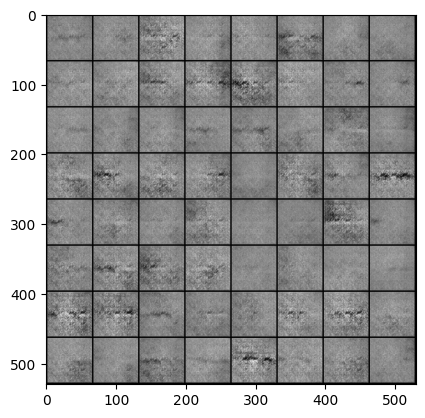

In [8]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread("/content/gdrive/MyDrive/Dev/AI_MsC/TFM/BestNotebooks/GAN-Simple_Pablo_v1/Images/fake_samples/fake_samples_epoch_069.png")
imgplot = plt.imshow(img)
plt.show()